<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Data Augmentation

One of the most important steps when building a model for Computer Vision is data augmentation.
Using more training data can make the model generalize better, but it is very expensive to collect data.
Instead, augmenting the training data with minor alterations has been proven to work well.

In this notebook, we explore why the data augmentation works and how it affects the result of different image classification problems, *[MNIST](http://yann.lecun.com/exdb/mnist/)* and *Fridge Objects*<sup>*</sup>. To make this task simple, we only test three basic transformation functions in [fastai](https://docs.fast.ai/vision.transform.html)--`get_transforms`, `zoom_crop` and `rand_resize_crop`--which have been working pretty well in a wide range of tasks with the default parameters.

<sub>* To learn more about Fridge Objects dataset and performance, check out [training introduction notebook](01_training_introduction.ipynb)</sub>

In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [51]:
import sys
sys.path.append("../")
from tempfile import TemporaryDirectory

import fastai
import pandas as pd
from fastai.vision import *
from fastai.metrics import accuracy

from utils_ic.constants import IMAGENET_IM_SIZE as IMAGE_SIZE
from utils_ic.datasets import unzip_url, Urls
from utils_ic.fastai_utils import TrainMetricsRecorder
from utils_ic.gpu_utils import which_processor
from utils_ic.plot_utils import plot_pr_roc_curves, ResultsWidget

print(f"Fast.ai version = {fastai.__version__}")
which_processor()

Fast.ai version = 1.0.48
Fast.ai (Torch) is using GPU: Tesla K80
Available / Total memory = 11430 / 11441 (MiB)


This shows your machine's GPUs (if has any) and which computing device fastai/torch is using. The output cells here show the run results on [Azure DSVM](https://azure.microsoft.com/en-us/services/virtual-machines/data-science-virtual-machines/) Standard NC6.

In [10]:
# Parameters
LEARNING_RATE = 1e-4
BATCH_SIZE    = 16
ARCHITECTURE  = models.resnet50
DATA_PATH     = 'data' # To cache the dataset for later use, set DATA_PATH

In [37]:
tmpdir = TemporaryDirectory()
if DATA_PATH is None:
    DATA_PATH = tmpdir.name
    
datasets = {}

## 1. Two different problems: Handwritten digit vs. Fridge object

TODO: Some texts here about how these two are different and why we picked these examples.


#### MNIST

In [27]:
# MNIST TINY
mnist_path = untar_data(
    URLs.MNIST_TINY,
    os.path.join(DATA_PATH, 'mnist.tgz'),
    DATA_PATH
)
mnist_path.ls()

/data/anaconda/envs/cvbp/lib/python3.6/site-packages/fastai/datasets.py:159: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


[PosixPath('data/mnist_tiny/models'),
 PosixPath('data/mnist_tiny/labels.csv'),
 PosixPath('data/mnist_tiny/test'),
 PosixPath('data/mnist_tiny/valid'),
 PosixPath('data/mnist_tiny/train')]

MNIST
Num train = 709, num valid = 699
Classes = ['3', '7']


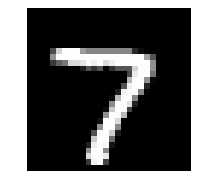

In [38]:
datasets['mnist'] = (
    ImageList.from_folder(mnist_path)
    .split_by_folder()
    .label_from_folder()
)

print("MNIST")
print(f"Num train = {len(datasets['mnist'].train)}, num valid = {len(datasets['mnist'].valid)}")
print(f"Classes = {datasets['mnist'].classes}")

datasets['mnist'].train.x[0].show()

#### Fridge Objects

In [29]:
fridge_path = unzip_url(Urls.fridge_objects_path, DATA_PATH, exist_ok=True)
fridge_path.ls()

[PosixPath('/data/home/jumin/git/cvbp/image_classification/notebooks/data/fridgeObjects/water_bottle'),
 PosixPath('/data/home/jumin/git/cvbp/image_classification/notebooks/data/fridgeObjects/carton'),
 PosixPath('/data/home/jumin/git/cvbp/image_classification/notebooks/data/fridgeObjects/can'),
 PosixPath('/data/home/jumin/git/cvbp/image_classification/notebooks/data/fridgeObjects/milk_bottle')]

Fridge object
Num train = 67, num valid = 67
Classes = ['can', 'carton', 'milk_bottle', 'water_bottle']


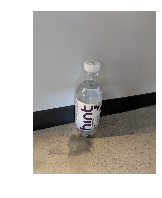

In [39]:
datasets['fridge'] = (
    ImageList.from_folder(fridge_path)
    .split_by_rand_pct(valid_pct=0.5, seed=10) 
    .label_from_folder()
)

print("Fridge object")
print(f"Num train = {len(datasets['fridge'].train)}, num valid = {len(datasets['fridge'].valid)}")
print(f"Classes = {datasets['fridge'].classes}")

datasets['fridge'].train.x[0].show()

## 2. Image transformation

We test following transformations:
1. No transforms
1. `get_transforms` with horizontal and vertical flips
1. `get_transforms` with horizontal flip
1. `get_transforms` without flip
1. `zoom_crop`
1. `rand_resize_crop`

Note, each transform functions returns a tuple of two list of transforms: one for the training set and one for the validation set (the second list of transforms is limited to resizing the pictures). For the full list of transformation `fastai` supports, see [its API documents](https://docs.fast.ai/vision.transform.html).

In [44]:
# We keep all the other parameters as defaults.
tfms_options = {
    'no_tfms': None,
    'flip': get_transforms(do_flip=True, flip_vert=True),
    'flip_no_vert': get_transforms(do_flip=True, flip_vert=False),
    'no_flip': get_transforms(do_flip=False),
    'zoom_crop': zoom_crop(scale=(0.75,2), do_rand=True),
    'rand_resize_crop': rand_resize_crop(224)
}

#### Examples of not-very-useful (or even bad) transformations vs. good transformations

Again, this will be pretty much dependent on the problem we would like to solve.


<img src="figs/augmentation_m_w.jpg" alt="m and w" width="200"/>

<center><i>You probablly do not want to vertical-flip letters</i></center>


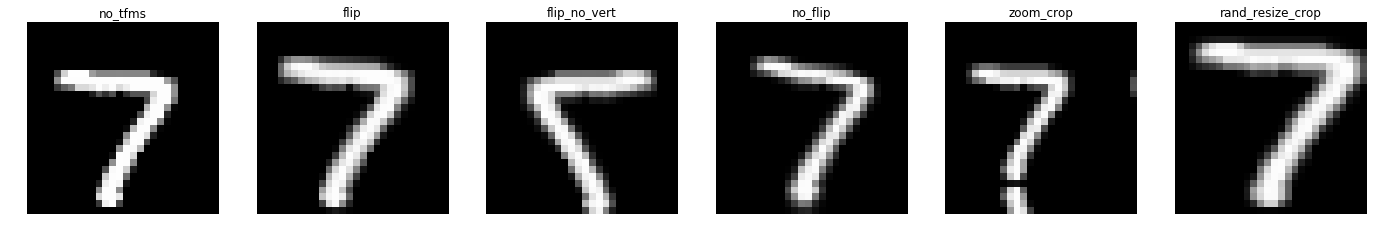

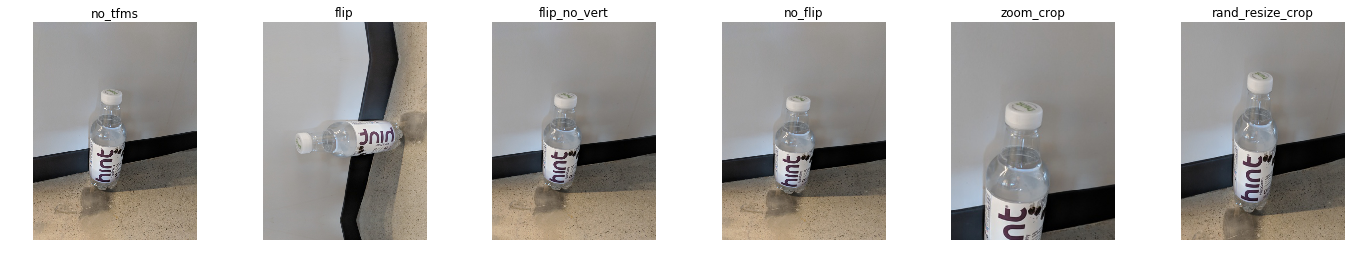

In [50]:
def plot_ex(im, tfms_ops):
    _, axes = plt.subplots(1, len(tfms_ops), figsize=(4*len(tfms_ops), 4))
    for i, (name, tfms) in enumerate(tfms_ops.items()):
        if tfms is None:
            im.show(ax=axes[i], title=name)
        else:
            im.apply_tfms(tfms[0]).show(ax=axes[i], title=name)  # tfms[0]: tfms for the training set

plot_ex(datasets['mnist'].train.x[0], tfms_options)
plot_ex(datasets['fridge'].train.x[0], tfms_options)

## 3. Training and evaluation 

In [54]:
df_results = pd.DataFrame(columns=['data', 'transform', 'train_acc', 'valid_acc'])

# for d_name, d in datasets.items():
#     for tfms_name, tfms in tfms_options.items():
d_name, d = 'fridge', datasets['fridge']
tfms_name, tfms = 'no_tfms', tfms_options['no_tfms']

data = d.transform(tfms, size=IMAGE_SIZE).databunch(bs=BATCH_SIZE).normalize(imagenet_stats)

learn = cnn_learner(
    data,
    ARCHITECTURE,
    metrics=[accuracy],
    callback_fns=[partial(TrainMetricsRecorder, silent=True)]
)
learn.fit_one_cycle(1, LEARNING_RATE)

train_metrics = learn.train_metrics_recorder.last_train_metrics()
valid_metrics = learn.train_metrics_recorder.last_valid_metrics()
row = [d_name, tfms_name, f"{100*float(train_metrics[0]):3.2f}", f"{100*float(valid_metrics[0]):3.2f}"]

df_results.loc[df_results.shape[0] + 1] = row

In [55]:
df_results

,data,transform,train_acc,valid_acc
1,fridge,no_tfms,12.50,32.84


In this notebook, we'll use a toy dataset called *Fridge Objects*, which consists of 134 images of can, carton, milk bottle and water bottle photos taken with different backgrounds. With our helper function, the data set will be downloaded and unzip to `image_classification/data`.

Let's set that directory to our `path` variable, which we'll use throughout the notebook, and checkout what's inside:

In [ ]:
path = Path(DATA_PATH)
path.ls()

You'll notice that we have four different folders inside:
- `/water_bottle`
- `/milk_bottle`
- `/carton`
- `/can`

## 2. Load Images

To use fastai, we want to create `ImageDataBunch` so that the library can easily use multiple images (mini-batches) during training time. We create an ImageDataBunch by using fastai's [data_block apis](https://docs.fast.ai/data_block.html).

For training and validation, we randomly split the data by 8:2, where 80% of the data is for training and the rest for validation. 

In [ ]:
data = (ImageList.from_folder(path) 
        .split_by_rand_pct(valid_pct=0.2, seed=10) 
        .label_from_folder() 
        .transform(size=IMAGE_SIZE) 
        .databunch(bs=BATCH_SIZE) 
        .normalize(imagenet_stats))

Lets take a look at our data using the databunch we created.

In [ ]:
data.show_batch(rows=3, figsize=(15,11))

Lets see all available classes:

In [ ]:
print(f'number of classes: {data.c}')
print(data.classes)

We can also see how many images we have in our training and validation set.

In [ ]:
data.batch_stats

In this notebook, we don't use test set. You can add it by using [add_test](https://docs.fast.ai/data_block.html#LabelLists.add_test). Please note that in the **fastai** framework, test datasets have no labels - this is the unknown data to be predicted. If you want to validate your model on a test dataset with labels, you probably need to use it as a validation set.

## 3. Train a Model

For the model, we use a convolutional neural network (CNN). Specifically, we'll use **ResNet50** architecture. You can find more details about ResNet from [here](https://arxiv.org/abs/1512.03385).

When training a model, there are many hypter parameters to select, such as the learning rate, the model architecture, layers to tune, and many more. With fastai, we can use the `create_cnn` function that allows us to specify the model architecture and performance indicator (metric). At this point, we already benefit from transfer learning since we download the parameters used to train on [ImageNet](http://www.image-net.org/).

Note, we use a custom callback `TrainMetricsRecorder` to track the accuracy on the training set during training, since fast.ai's default [recorder class](https://docs.fast.ai/basic_train.html#Recorder) only supports tracking accuracy on the validation set.

In [ ]:
learn = cnn_learner(
    data,
    ARCHITECTURE,
    metrics=[accuracy],
    callback_fns=[partial(TrainMetricsRecorder, show_graph=True)]
)

Unfreeze our CNN since we're training all the layers.

In [ ]:
learn.unfreeze()

We can call the `fit` function to train the dnn.

In [ ]:
learn.fit(EPOCHS, LEARNING_RATE)

In [ ]:
# You can plot loss by using the default callback Recorder.
learn.recorder.plot_losses()

## 4. Evaluate the Model

To evaluate our model, lets take a look at the accuracy on the validation set.

In [ ]:
_, metric = learn.validate(learn.data.valid_dl, metrics=[accuracy])
print(f'Accuracy on validation set: {100*float(metric):3.2f}')

Now, analyze the classification results by using `ClassificationInterpretation` module.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
# Get prediction scores. We convert tensors to numpy array to plot them later.
pred_scores = to_np(interp.probs)

We can plot precision-recall and ROC curves for each class as well. Please note that these plots are not too interesting here, since the dataset is easy and thus the accuracy is close to 100%.

In [ ]:
# True labels of the validation set. We convert to numpy array for plotting.
true_labels = to_np(interp.y_true)
plot_pr_roc_curves(true_labels, pred_scores, data.classes)

Let's take a close look how our model confused some of the samples (if any). The most common way to do that is to use a confusion matrix.

In [ ]:
interp.plot_confusion_matrix()

When evaluating our results, we want to see where the model messes up, and whether or not we can do better. So we're interested in seeing images where the model predicted the image incorrectly but with high confidence (images with the highest loss).

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

That's pretty much it! Now you can bring your own dataset and train your model on them easily. 

In [36]:
# Cleanup
tmpdir.cleanup()